# Understanding Bayesian Optimization

A simple worked through example of using BO to find the minimum of a one dimensional function

The majority of this is taken from  *Gaussian processes for machine learning* by C. E. Rasmussen and C. K. I. Williams.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

### Target function and input domain

We start by defning the target funtion and generating the input domain, x_true 

Text(0.5,0,u'x')

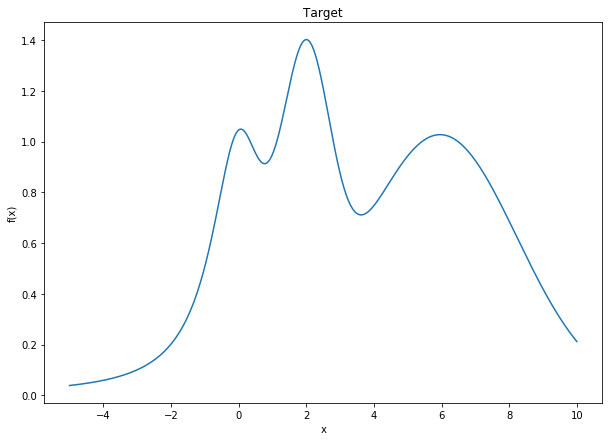

In [112]:
# Define the function we're trying to minimize 
def f(x):
    return x**2

def f(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

# define a set of measurmenets
min_x,max_x, n_samples = -5,10,4
# True distirubtuion
X_true =  np.linspace(min_x,max_x,1000) 
f_x_true = [f(x) for x in X_true]

# PSeudo data, we made n_sample measurements
plt.plot(X_true,f_x_true)
plt.title('Target')
plt.ylabel('f(x)')
plt.xlabel('x')

## Visualizing samples from a Gaussian process

We need to first define a kernel,or covariance, between the a test set of inputs X_test. We are going to first draw a few lines

Then we're going to draw samples of gaussian process given the conditional obserations already made  

In [113]:
def kernel(X,X_prime):
    """
        The covariance or kernel of the gaussian processes used to minimize 
        this example
        
        Sometimes this covariance function is called the Radial Basis Function (RBF) or Gaussian;
        here we prefer squared exponential.
    """
    K =  []
    for i,x in enumerate(X):
        row = []
        for j,x_p in enumerate(X_prime):
            row.append( np.exp( -0.5*np .square( x - x_p )) )
        K.append( row  )
    return np.array(K)

#### Unconditional sampling from Gaussian process

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


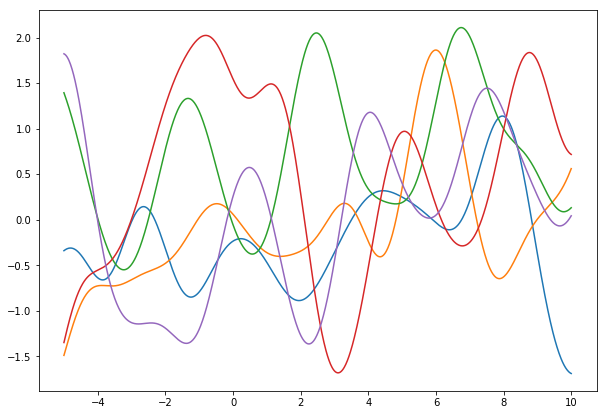

In [115]:
# Geneate the kernal matrix and cahce it so we don't run this costlye process every time 
Sigma =  kernel( X_true,X_true )

for n_examples in xrange(5): 
    plt.plot(X_true,np.random.multivariate_normal(np.zeros(len(X_true)), Sigma))
%time

### Conditional sampling from Gaussian process

We now want to evaluate a postierier distribution given our observation set X. From this we want to asses where is the next best choice for a new value 

In [116]:
def postierier(x,X,f_X):
    """ 
    The postier function given input:
        x: distibution in x to be tested over 
        X: measured X that will be integrated out 
        f_X: measured Y associated with each point x    
    """
    k_xX = kernel(x,X)
    k_XX = kernel(X,X)
    k_XX_inv = np.linalg.inv(k_XX)
    k_xx = kernel(x,x)
    k_Xx = kernel(X,x)
    
    mean = np.matmul(k_XX_inv,f_x )
    mean = np.matmul( k_xX, mean)

    sigma = np.matmul(k_XX_inv, k_Xx)
    sigma = np.matmul(k_xX, sigma)
    sigma = k_xx - sigma
    return mean, sigma

from scipy.stats import multivariate_normal
def utility(x,f_x, m,sigma):
    """
        expected improvement acquisition
    """
    f_min = np.min(f_x)
    Z = np.divide( (-m  +f_min), sigma)
    return np.nan_to_num(np.multiply(-m+f_min,norm.cdf(f_min,m,sigma  )) + np.multiply(sigma, norm.pdf(Z) ))

In [117]:
X =  np.linspace(min_x,max_x,2) 
f_X = [f(x) for x in X]

m, s = postierier(X_true, X,f_x ) 
sig = np.diag(s) 

# Draw the 3 sigma band of the postier distirbution
plt.fill_between(X_true, m - 3*sig, m+3*sig,alpha=0.5,color='green')
plt.fill_between(X_true, m - 2*sig, m+2*sig,alpha=0.5,color='yellow')

# sample and draw a few postieriers 
for n_examples in xrange(1,3): 
    plt.plot(X_true,np.random.multivariate_normal(m,s))
# Draw the means 
plt.plot(X_true,m,color = 'black')
plt.plot(X,f_X,'bo')
plt.show()

# Draw the utility function for the current postier 
u = utility(X,f_x, m, sig)
x_max, u_max = X_true[np.argmax(u)],np.max(u)
plt.fill_between(X_true, 0,u,alpha=0.5,color='blue')
plt.plot( [x_max],[u_max], 'y*',
          markersize=24)

ValueError: shapes (2,2) and (4,) not aligned: 2 (dim 1) != 4 (dim 0)

## Performing an optimization

Next lets define an acquisition function this informs of the usefulness of a point on postier
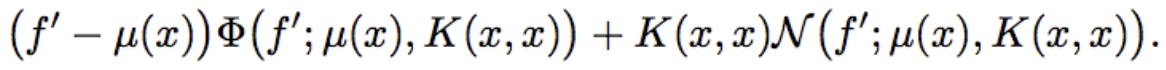